In [150]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import Delaunay
from scipy.interpolate import RectBivariateSpline
from skimage import io
from matplotlib.path import Path
import imageio
import json
import os

(750, 602, 3)
(750, 602, 3)


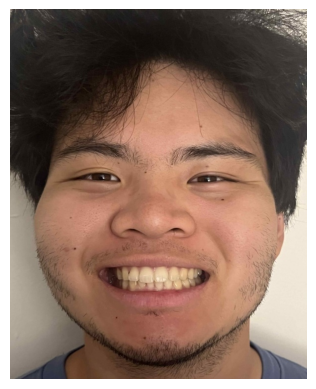

In [89]:
image1 = cv2.imread('photos/toby.jpg')
image2 = cv2.imread('photos/jonny_resized.jpg')

print(image1.shape)
print(image2.shape)

height, width, _ = image1.shape

image2_resized = cv2.resize(image2, (width, height), interpolation=cv2.INTER_AREA)

cv2.imwrite('photos/jonny_resized.jpg', image2_resized)

plt.imshow(cv2.cvtColor(image2_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

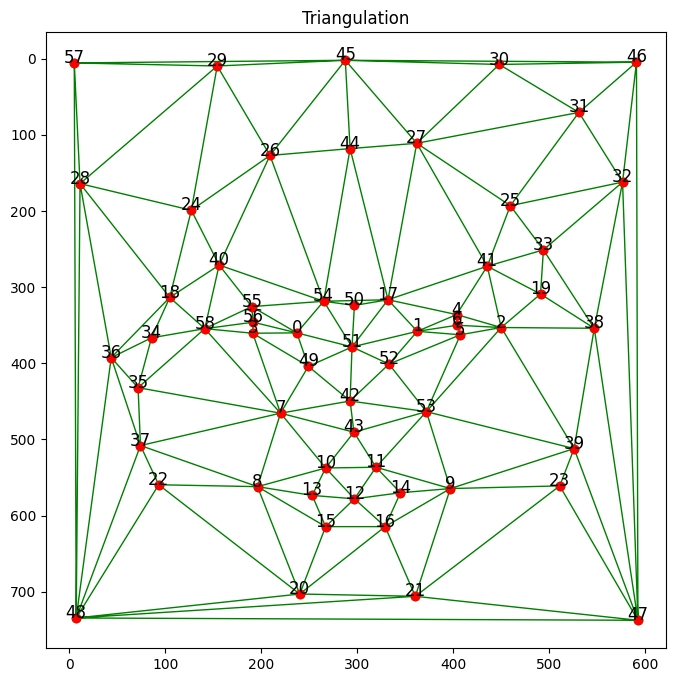

In [130]:
with open('saved_points/toby_jonny.json', 'r') as file:
    data = json.load(file)

points1 = np.array(data['im1Points'])
points2 = np.array(data['im2Points'])


def get_tri(points1, points2):
    midway_shape = (points1 + points2) / 2
    return Delaunay(midway_shape), midway_shape

tri, midway_shape = get_tri(points1, points2)

plt.figure(figsize=(8, 8))
plt.triplot(midway_shape[:, 0], midway_shape[:, 1], tri.simplices, 'go-', lw=1)
plt.plot(midway_shape[:, 0], midway_shape[:, 1], 'ro')
for i, (x, y) in enumerate(midway_shape):
    plt.text(x, y, f'{i}', fontsize=12, ha='center')
plt.gca().invert_yaxis()
plt.title("Triangulation")
plt.show()


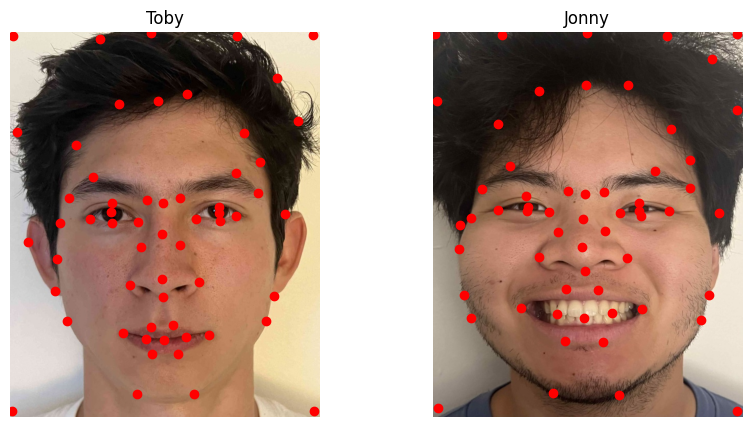

In [286]:
toby = io.imread('photos/toby.jpg')
jonny = io.imread('photos/jonny.jpg')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(toby)
ax[0].plot(points1[:, 0], points1[:, 1], 'ro')
ax[0].axis('off')
ax[0].set_title('Toby')
ax[1].imshow(jonny)
ax[1].plot(points2[:, 0], points2[:, 1], 'ro')
ax[1].axis('off')
ax[1].set_title('Jonny')
plt.show()

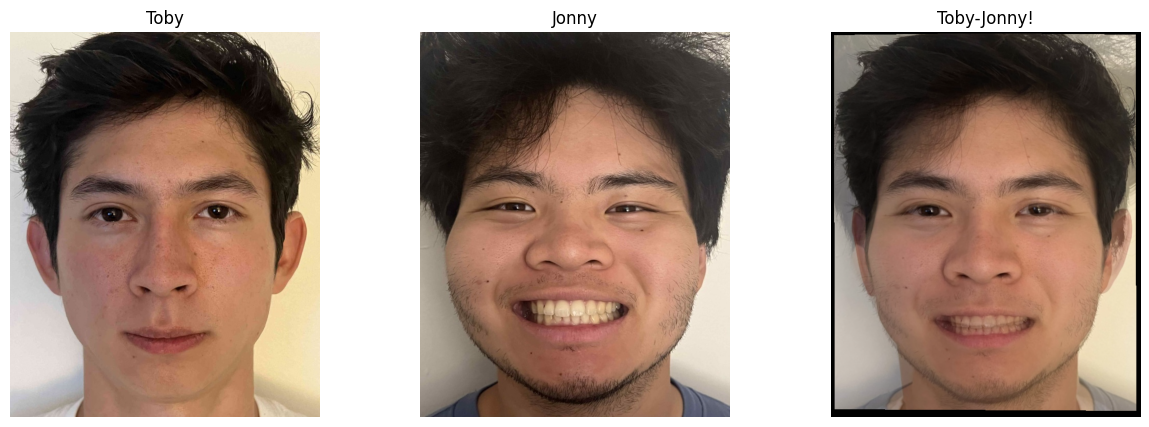

In [144]:
src_img = io.imread('photos/toby.jpg').astype(np.float64)
dst_img = io.imread('photos/jonny.jpg').astype(np.float64)

with open('saved_points/toby_jonny.json', 'r') as file:
    data = json.load(file)

src_pts = np.array(data['im1Points'])
dst_pts = np.array(data['im2Points'])

tri, midway_shape = get_tri(src_pts, dst_pts)

def computeAffine(pts, tri2):
    return np.linalg.lstsq(
        np.hstack((pts, np.ones((3, 1)))), 
        tri2, 
        rcond=None
    )[0].T

src_height, src_width = src_img.shape[:2]
dst_height, dst_width = dst_img.shape[:2]

src_interps = [
    RectBivariateSpline(np.arange(src_height), np.arange(src_width), src_img[:, :, i], kx=1, ky=1)
    for i in range(3)
]
dst_interps = [
    RectBivariateSpline(np.arange(dst_height), np.arange(dst_width), dst_img[:, :, i], kx=1, ky=1)
    for i in range(3)
]

midway_face = np.zeros_like(src_img)

for tri_idx in tri.simplices:
    pts_mid = midway_shape[tri_idx]
    A1 = computeAffine(pts_mid, points1[tri_idx])
    A2 = computeAffine(pts_mid, points2[tri_idx])
    x = pts_mid[:, 0]
    y = pts_mid[:, 1]

    min_x = int(np.min(x))
    max_x = int(np.max(x))
    min_y = int(np.min(y))
    max_y = int(np.max(y))
    grid_x, grid_y = np.meshgrid(np.arange(min_x, max_x + 1), np.arange(min_y, max_y + 1))
    grid_x_flat = grid_x.flatten()
    grid_y_flat = grid_y.flatten()

    tri_path = Path(np.vstack((x, y)).T)
    points = np.vstack((grid_x_flat, grid_y_flat)).T
    mask = tri_path.contains_points(points)
    masked_x = grid_x_flat[mask].astype(int)
    masked_y = grid_y_flat[mask].astype(int)

    ones = np.ones_like(masked_x)
    pixels = np.vstack((masked_x, masked_y, ones)).T

    src_crds = pixels @ A1.T
    dst_crds = pixels @ A2.T

    src_x = src_crds[:, 0]
    src_y = src_crds[:, 1]
    dst_x = dst_crds[:, 0]
    dst_y = dst_crds[:, 1]

    warped_src = np.zeros((len(src_x), 3))
    warped_dst = np.zeros((len(dst_x), 3))

    for i in range(3):
        src_interp, dst_interp = src_interps[i], dst_interps[i]
        warped_src[:, i] = src_interp(src_y, src_x, grid=False)
        warped_dst[:, i] = dst_interp(dst_y, dst_x, grid=False)

    midway_face[masked_y, masked_x] = (warped_src + warped_dst) / 2

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(src_img.astype(np.uint8))
plt.title('Toby')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dst_img.astype(np.uint8))
plt.title('Jonny')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(midway_face.astype(np.uint8))
plt.title('Toby-Jonny!')
plt.axis('off')

plt.show()

In [129]:
midway_face_path = 'results/toby_jonny_midway.jpg'
io.imsave(midway_face_path, midway_face.astype(np.uint8))


In [148]:
def morph(src_img, dst_img, src_pts, dst_pts, triangles, warp, dissolve):
    midway_shape = (1 - warp) * src_pts + warp * dst_pts
    src_height, src_width = src_img.shape[:2]
    dst_height, dst_width = dst_img.shape[:2]
    
    src_interps = [
        RectBivariateSpline(np.arange(src_height), np.arange(src_width), src_img[:, :, i], kx=1, ky=1)
        for i in range(3)
    ]
    dst_interps = [
        RectBivariateSpline(np.arange(dst_height), np.arange(dst_width), dst_img[:, :, i], kx=1, ky=1)
        for i in range(3)
    ]
    
    res = np.zeros((src_height, src_width, 3))
    
    for tri_idx in triangles.simplices:
        src_triangle = src_pts[tri_idx]
        dst_triangle = dst_pts[tri_idx]
        midway_triangle = midway_shape[tri_idx]
        
        affine_src = computeAffine(midway_triangle, src_triangle)
        affine_dst = computeAffine(midway_triangle, dst_triangle)
        
        x_coords = midway_triangle[:, 0]
        y_coords = midway_triangle[:, 1]
        
        min_x = int(np.min(x_coords))
        max_x = int(np.max(x_coords))
        min_y = int(np.min(y_coords))
        max_y = int(np.max(y_coords))
        grid_x, grid_y = np.meshgrid(np.arange(min_x, max_x + 1), np.arange(min_y, max_y + 1))
        grid_x = grid_x.flatten()
        grid_y = grid_y.flatten()
        
        triangle_path = Path(np.vstack((x_coords, y_coords)).T)
        grid_points = np.vstack((grid_x, grid_y)).T
        mask = triangle_path.contains_points(grid_points)
        masked_x = grid_x[mask].astype(int)
        masked_y = grid_y[mask].astype(int)
        
        homog_crds = np.vstack((masked_x, masked_y, np.ones_like(masked_x))).T
        src_crds = homog_crds @ affine_src.T
        dst_crds = homog_crds @ affine_dst.T

        src_x = src_crds[:, 0]
        src_y = src_crds[:, 1]
        dst_x = dst_crds[:, 0]
        dst_y = dst_crds[:, 1]

        warped_src = np.zeros((len(src_x), 3))
        warped_dst = np.zeros((len(dst_x), 3))

        for channel in range(3):
            src_interp, dst_interp = src_interps[channel], dst_interps[channel]
            warped_src[:, channel] = src_interp(src_y, src_x, grid=False)
            warped_dst[:, channel] = dst_interp(dst_y, dst_x, grid=False)

        res[masked_y, masked_x] = (1 - dissolve) * warped_src + dissolve * warped_dst
    
    return res

In [149]:
im1 = io.imread('photos/toby.jpg').astype(np.float64)
im2 = io.imread('photos/jonny.jpg').astype(np.float64)

with open('saved_points/toby_jonny.json', 'r') as file:
    data = json.load(file)

src_pts = np.array(data['im1Points'])
dst_pts = np.array(data['im2Points'])
tri, _ = get_tri(src_pts, dst_pts)

num_frames = 45
warp_params = np.linspace(0, 1, num_frames)
dissolve_params = np.linspace(0, 1, num_frames)

frames = []

for i in range(num_frames):
    warp_frac, dissolve_frac = warp_params[i], dissolve_params[i]
    morphed = morph(im1, im2, src_pts, dst_pts, tri, warp_frac, dissolve_frac)
    frames.append(np.clip(morphed, 0, 255).astype(np.uint8))
    print(f"Frame #{i}")

imageio.mimsave('morph_sequence.gif', frames, fps=30)

Generated frame #0
Generated frame #1
Generated frame #2
Generated frame #3
Generated frame #4
Generated frame #5
Generated frame #6
Generated frame #7
Generated frame #8
Generated frame #9
Generated frame #10
Generated frame #11
Generated frame #12
Generated frame #13
Generated frame #14
Generated frame #15
Generated frame #16
Generated frame #17
Generated frame #18
Generated frame #19
Generated frame #20
Generated frame #21
Generated frame #22
Generated frame #23
Generated frame #24
Generated frame #25
Generated frame #26
Generated frame #27
Generated frame #28
Generated frame #29
Generated frame #30
Generated frame #31
Generated frame #32
Generated frame #33
Generated frame #34
Generated frame #35
Generated frame #36
Generated frame #37
Generated frame #38
Generated frame #39
Generated frame #40
Generated frame #41
Generated frame #42
Generated frame #43
Generated frame #44
Morph sequence saved as 'morph_sequence.gif'


In [251]:
population_dir = 'population/'
all_points = []
for filename in os.listdir(population_dir):
    if filename.endswith('.pts'):
        filepath = os.path.join(population_dir, filename)
        with open(filepath, 'r') as file:
            lines = file.readlines()
            start_idx = lines.index('{\n') + 1
            end_idx = lines.index('}\n')
            points = []
            for line in lines[start_idx:end_idx]:
                x_str, y_str = line.strip().split()
                x = float(x_str)
                y = float(y_str)
                points.append([x, y])
            points.append([0, 0])
            points.append([249, 0])
            points.append([0, 299])
            points.append([249, 299])
            all_points.append(points)

all_points = np.array(all_points)
all_points.shape

(400, 50, 2)

In [252]:
average_shape = np.mean(all_points, axis=0)
average_shape.shape

(50, 2)

In [200]:
def morph_bw(src_img, src_pts, dst_pts, triangles):
    src_height, src_width = src_img.shape[:2]
    num_channels = 1
    src_img_channels = [src_img]
    
    src_interps = [
        RectBivariateSpline(np.arange(src_height), np.arange(src_width), src_channel, kx=1, ky=1)
        for src_channel in src_img_channels
    ]
    
    res = np.zeros((src_height * 1, src_width * 1))
    
    for tri_idx in triangles.simplices:
        src_triangle = src_pts[tri_idx]
        triangle = dst_pts[tri_idx]
        
        affine_src = computeAffine(triangle, src_triangle)
        
        x_coords = triangle[:, 0]
        y_coords = triangle[:, 1]
        min_x = int(np.floor(np.min(x_coords)))
        max_x = int(np.ceil(np.max(x_coords)))
        min_y = int(np.floor(np.min(y_coords)))
        max_y = int(np.ceil(np.max(y_coords)))
        grid_x, grid_y = np.meshgrid(np.arange(min_x, max_x + 1), np.arange(min_y, max_y + 1))
        grid_x = grid_x.flatten()
        grid_y = grid_y.flatten()
        
        triangle_path = Path(np.vstack((x_coords, y_coords)).T)
        grid_points = np.vstack((grid_x, grid_y)).T
        mask = triangle_path.contains_points(grid_points)
        masked_x = grid_x[mask]
        masked_y = grid_y[mask]
        
        homog_crds = np.vstack((masked_x, masked_y, np.ones_like(masked_x))).T
        src_crds = homog_crds @ affine_src.T

        src_x = src_crds[:, 0]
        src_y = src_crds[:, 1]

        warped_src = np.zeros((len(src_x), num_channels))

        for channel in range(num_channels):
            src_interp = src_interps[channel]
            warped_src[:, channel] = src_interp(src_y, src_x, grid=False)

        res[masked_y.astype(int), masked_x.astype(int)] = warped_src[:, 0]

    return res

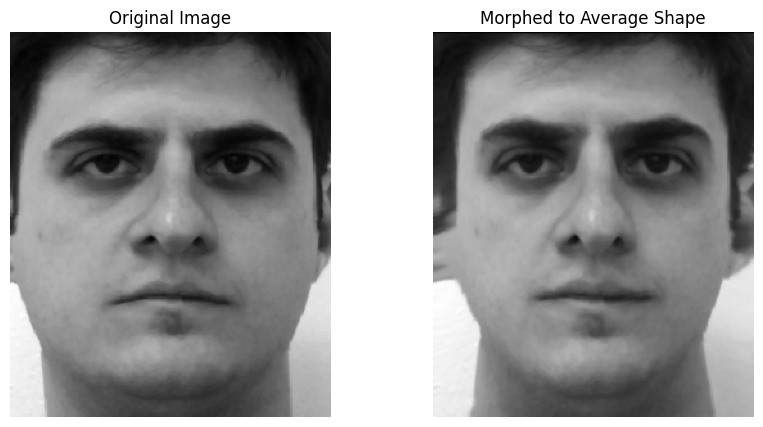

In [226]:
image_name = "1a"

image = io.imread(os.path.join(population_dir, f"{image_name}.jpg")).astype(np.float64)

with open(os.path.join(population_dir, f'{image_name}.pts'), 'r') as file:
    lines = file.readlines()
    start_idx = lines.index('{\n') + 1
    end_idx = lines.index('}\n')
    points = []
    for line in lines[start_idx:end_idx]:
        x_str, y_str = line.strip().split()
        x = float(x_str)
        y = float(y_str)
        points.append([x, y])
    points.append([0, 0])
    points.append([249, 0])
    points.append([0, 299])
    points.append([249, 299])
        
morphed_image = morph_bw(image, np.array(points), average_shape, Delaunay(average_shape))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(morphed_image, 0, 255), cmap='gray')
plt.title('Morphed to Average Shape')
plt.axis('off')

plt.show()

In [222]:
population_dir = 'population/'

image_sum = None
num_images = 0

all_points = []

for filename in os.listdir(population_dir):
    if filename.endswith('.pts'):
        filepath = os.path.join(population_dir, filename)
        with open(filepath, 'r') as file:
            lines = file.readlines()
            start_idx = lines.index('{\n') + 1
            end_idx = lines.index('}\n')
            points = []
            for line in lines[start_idx:end_idx]:
                x_str, y_str = line.strip().split()
                x = float(x_str)
                y = float(y_str)
                points.append([x, y])
        all_points.append(points)

all_points = np.array(all_points)
average_shape = np.mean(all_points, axis=0)
width, height = 250, 300
average_shape = np.vstack([
    average_shape,
    [0, 0],
    [width - 1, 0],
    [0, height - 1],
    [width - 1, height - 1]
])
triangles = Delaunay(average_shape)
for filename in os.listdir(population_dir):
    if filename.endswith('a.jpg'):
        image_name = filename[:-4]
        image_path = os.path.join(population_dir, filename)
        image = io.imread(image_path).astype(np.float64)
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.mean(image, axis=2)
        
        points_path = os.path.join(population_dir, f'{image_name}.pts')
        with open(points_path, 'r') as file:
            lines = file.readlines()
            start_idx = lines.index('{\n') + 1
            end_idx = lines.index('}\n')
            points = []
            for line in lines[start_idx:end_idx]:
                x_str, y_str = line.strip().split()
                x = float(x_str)
                y = float(y_str)
                points.append([x, y])
        points = np.array(points)
        height, width = image.shape[:2]
        points = np.vstack([
            points,
            [0, 0],
            [width - 1, 0],
            [0, height - 1],
            [width - 1, height - 1]
        ])
        warped_image = morph_bw(image, points, average_shape, triangles)
        if image_sum is None: image_sum = warped_image
        else: image_sum += warped_image
        num_images += 1
average_face = image_sum / num_images
average_face = np.clip(average_face, 0, 255)

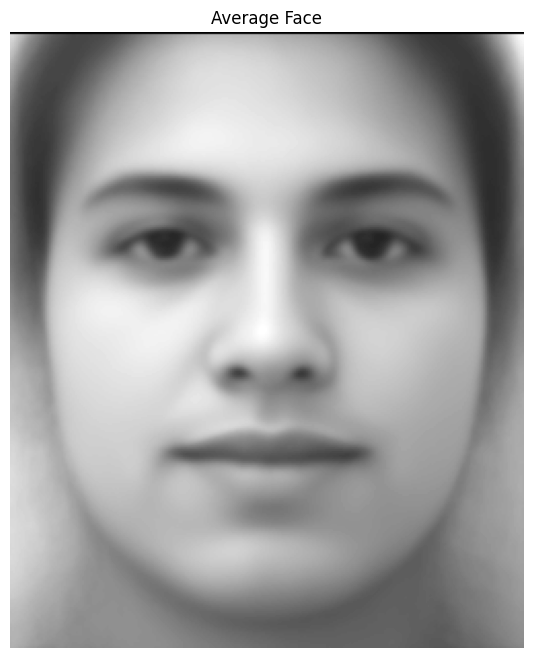

In [247]:
average_face_path = 'results/average_face.jpg'
io.imsave(average_face_path, average_face.astype(np.uint8))

plt.figure(figsize=(8, 8))
plt.imshow(average_face.astype(np.uint8), cmap='gray')
plt.title('Average Face')
plt.axis('off')
plt.show()

(300, 250)


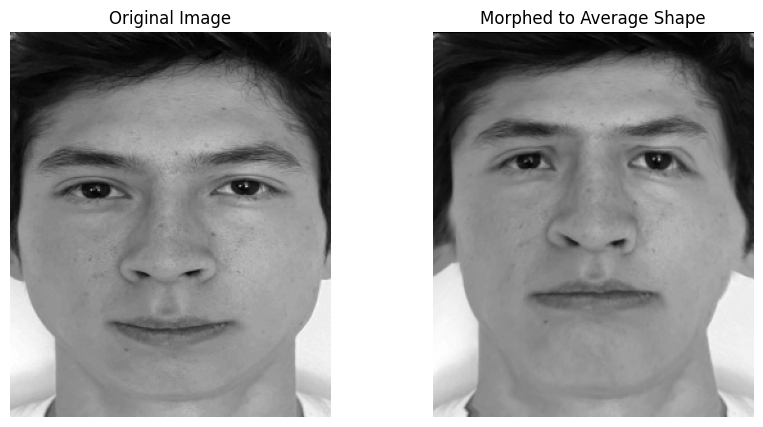

In [265]:
image = io.imread('photos/toby_population.jpg').astype(np.float64)

print(image.shape)
with open('saved_points/1a_toby_population.json', 'r') as file:
    data = json.load(file)
points = np.array(data['im2Points'])

points = points.tolist()
points.append([0, 0])
points.append([249, 0])
points.append([0, 299])
points.append([249, 299])

morphed_image = morph_bw(image, np.array(points), average_shape, Delaunay(average_shape))
morphed_image_path = 'results/toby_population_average.jpg'
io.imsave(morphed_image_path, morphed_image.astype(np.uint8))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(morphed_image, 0, 255), cmap='gray')
plt.title('Morphed to Average Shape')
plt.axis('off')

plt.show()

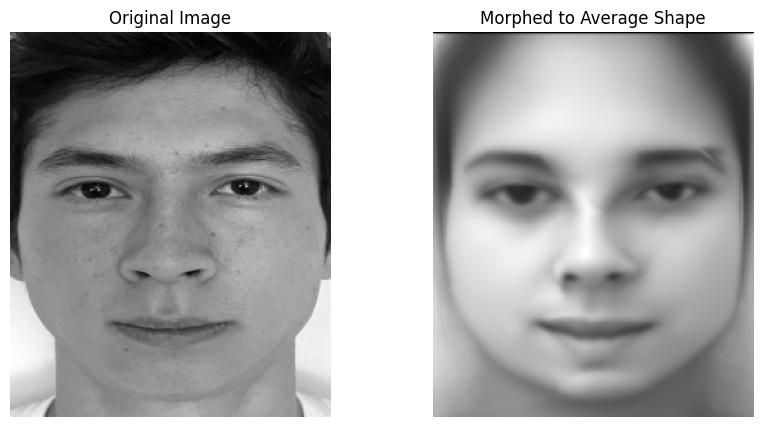

In [280]:
with open('saved_points/1a_toby_population.json', 'r') as file:
    data = json.load(file)
points = np.array(data['im2Points'])

points = points.tolist()
points.append([0, 0])
points.append([249, 0])
points.append([0, 299])
points.append([249, 299])

points_int = np.array(points).astype(int)
average_shape_int = average_shape.astype(int)
morphed_image = morph_bw(average_face, average_shape_int, points_int, Delaunay(points))

morphed_image_path = 'results/average_face_toby_population.jpg'
io.imsave(morphed_image_path, morphed_image.astype(np.uint8))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(morphed_image, 0, 255), cmap='gray')
plt.title('Morphed to Average Shape')
plt.axis('off')

plt.show()

(50, 2)


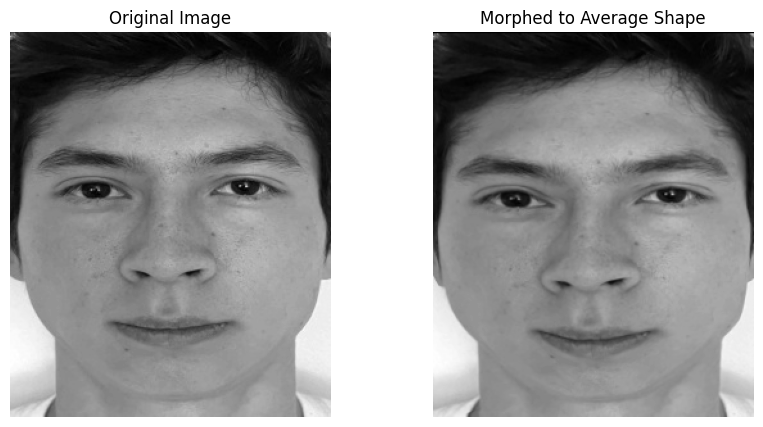

In [284]:
alpha = 1.3

image = io.imread('photos/toby_population.jpg').astype(np.float64)

with open('saved_points/1a_toby_population.json', 'r') as file:
    data = json.load(file)
points = np.array(data['im2Points'])

points = points.tolist()
points.append([0, 0])
points.append([249, 0])
points.append([0, 299])
points.append([249, 299])
points = np.array(points).astype(int)

car_shape = alpha * (points - average_shape) + average_shape
print(car_shape.shape)
morphed_image = morph_bw(image, points_int, car_shape, Delaunay(car_shape))

morphed_image_path = f'results/carac_face_alpha_{alpha}.jpg'
io.imsave(morphed_image_path, morphed_image.astype(np.uint8))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(morphed_image, 0, 255), cmap='gray')
plt.title('Morphed to Average Shape')
plt.axis('off')

plt.show()